# Prediction model tuning

The prediction models were further tuned on the selected data framework. This included methods for dealing with imbalanced data, such as upsampling the minor class using the `imbalanced-learn` package.

In [3]:
import pandas as pd
import numpy as np
import dill

from imblearn.pipeline import make_pipeline
from imblearn.ensemble import EasyEnsemble, BalanceCascade
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import auc, accuracy_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.base import BaseEstimator, ClassifierMixin

from scipy.stats import mode

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

/home/abhijit/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/abhijit/anaconda3/envs/idp/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
class MYVC(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers=None):
        self.classifiers = classifiers

    def fit(self, X, y):
        for classifier in self.classifiers:
            classifier.fit(X, y)

    def predict_proba(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            self.predictions_.append(classifier.predict_proba(X))
        return np.mean(self.predictions_, axis=0)
    
    def predict(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            self.predictions_.append(classifier.predict(X))
        return mode(self.predictions_, axis=0).mode[0]

## Combine data

First import and normalize the features.

In [35]:


with open('./pkl/11_features_engineered.pkl', 'rb') as fh:
    features = dill.load(fh)
features.head()
# features = features.drop(['index', 'country'], axis=1).T.groupby(level=0).first().T.dropna()
features['date'] = pd.to_datetime(features['date'])

for col in features.columns:
    if col not in ['date', 'location']:
        features[col] = features[col].astype(np.float)

In [38]:
feat_cols = [x for x in features.columns if x not in ['date','location']]
features[feat_cols] = Normalizer().fit_transform(features[feat_cols])

Import the predictors.

In [84]:
#framework_a_first = pd.read_pickle('../pkl/10_class_balancing_framework_a_first.pkl')
framework_a_first = pd.read_pickle('./pkl/10_class_balancing_fwf.pkl')

In [85]:
print (framework_a_first.shape, framework_a_first.isnull().sum().max())

fwd_a_first = pd.merge(framework_a_first, 
                       features, 
                       on=['date','location'], how='left').dropna()

print (fwd_a_first.shape, fwd_a_first.isnull().sum().max())

print (fwd_a_first.zika_bool.value_counts())

(1605, 5) 0
(1213, 29) 0
1    1004
0     209
Name: zika_bool, dtype: int64


Split the data into train and test portions.

In [86]:
train, test = train_test_split(fwd_a_first, test_size=0.30, random_state=42)

adasyn_3 = ADASYN(k=3)
X_resampled_3, Y_resampled_3 = adasyn_3.fit_sample(train[feat_cols], train['zika_bool'])

adasyn_5 = ADASYN(k=5)
X_resampled_5, Y_resampled_5 = adasyn_5.fit_sample(train[feat_cols], train['zika_bool'])

adasyn_7 = ADASYN(k=7)
X_resampled_7, Y_resampled_7 = adasyn_7.fit_sample(train[feat_cols], train['zika_bool'])

enn_3 = EditedNearestNeighbours(size_ngh=3)
X_dwnresampled_3, Y_dwnresampled_3 = enn_3.fit_sample(train[feat_cols], train['zika_bool'])

enn_5 = EditedNearestNeighbours(size_ngh=5)
X_dwnresampled_5, Y_dwnresampled_5 = enn_5.fit_sample(train[feat_cols], train['zika_bool'])

enn_7 = EditedNearestNeighbours(size_ngh=7)
X_dwnresampled_7, Y_dwnresampled_7 = enn_7.fit_sample(train[feat_cols], train['zika_bool'])

Ytest = test['zika_bool']
Xtest = test[feat_cols+['date','location']]

/home/abhijit/.local/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)
/home/abhijit/.local/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)
/home/abhijit/.local/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)
/home/abhijit/.local/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated from 0.2 and will be removed in 0.4. Use 'n_neighbors' instead.
  category=DeprecationWarning)
/home/abhijit/.local/lib/python3.6/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'size_ngh' is deprecated f

In [87]:
test

,location,cases_first_date,cases_total,date,zika_bool,max_temp,max_temp1,max_temp2,mean_temp,mean_temp1,...,precipitation2,wind,wind1,wind2,density_per_km,airport_dist_any,airport_dist_large,mosquito_dist,gdp,gdp_ppp
609,Colombia-Cordoba-San_Jose_De_Ure,0,421,2016-01-16,1,0.112614,0.112823,0.052550,0.107448,0.106978,...,0.000019,0.010437,0.010646,0.012837,0.042008,1.914334e-04,1.493631e-02,1.263290e-03,0.380295,0.870047
1192,Colombia-Valle_Del_Cauca-Dagua,0,685,2016-02-20,1,0.122832,0.044059,0.042724,0.106810,0.036048,...,0.000000,0.008011,0.013351,0.010681,0.060120,1.451688e-04,1.009356e-02,9.702158e-05,0.389189,0.890395
46,Brazil-Rio_de_Janeiro,229,263516,2016-02-13,1,0.008017,0.008518,0.022547,0.007015,0.007265,...,0.000030,0.002505,0.002505,0.001253,0.377058,2.702702e-08,3.665017e-06,3.236365e-06,0.450859,0.807774
170,Colombia-Antioquia-Segovia,0,31,2016-03-05,1,0.110220,0.111384,0.064532,0.100234,0.101883,...,0.016547,0.007224,0.008389,0.012511,0.039093,3.647949e-04,7.797043e-03,3.601614e-04,0.381489,0.872778
781,Colombia-Huila-Nataga,0,99,2016-01-23,1,0.122610,0.121333,0.120056,0.111116,0.109838,...,0.000920,0.003832,0.003832,0.002554,0.067342,5.473314e-04,9.464741e-03,1.151520e-03,0.372301,0.851759
890,Colombia-Narino-La_Cruz,0,0,2016-01-09,0,0.097630,0.102837,0.104139,0.087216,0.092423,...,0.000000,0.003905,0.014319,0.013017,0.113540,1.877327e-04,6.398338e-03,1.140826e-03,0.379457,0.868129
337,Colombia-Boyaca-Jerico,0,0,2016-01-09,0,0.108539,0.109832,0.111124,0.096910,0.098202,...,0.000000,0.005169,0.009045,0.006461,0.112776,2.826088e-04,4.960211e-03,2.932230e-04,0.376658,0.861726
905,Colombia-Narino-Policarpa,0,15,2016-03-19,1,0.032766,0.032766,0.031401,0.027305,0.027305,...,0.000000,0.006826,0.006826,0.004096,0.065199,1.132659e-04,5.319330e-03,1.731369e-03,0.397970,0.910485
135,Colombia-Antioquia-Montebello,0,5,2016-05-28,1,0.096923,0.099543,0.028815,0.085135,0.085135,...,0.034264,0.005239,0.005239,0.006549,0.180592,7.588692e-05,4.511838e-03,1.007610e-04,0.381800,0.873490
124,Colombia-Antioquia-Ituango,0,20,2016-02-13,1,0.040263,0.040263,0.114078,0.032210,0.032210,...,0.000000,0.012079,0.013421,0.006710,0.020645,1.258380e-03,1.170411e-02,5.816926e-04,0.391220,0.895042


In [88]:
data_names = ['unbalanced','upsampled_3','upsampled_5','upsampled_7',
             'dwnsampled_3', 'dwnsampled_5', 'dwnsampled_7']
xdata_list = [train[feat_cols], X_resampled_3, X_resampled_5, X_resampled_7, 
              X_dwnresampled_3, X_dwnresampled_5, X_dwnresampled_7]
ydata_list = [train['zika_bool'], Y_resampled_3, Y_resampled_5, Y_resampled_7, 
              Y_dwnresampled_3, Y_dwnresampled_5, Y_dwnresampled_7]


In [89]:
def error_calc(model, label, Ytest=Ytest):
    
    Ypred = model.predict(test[feat_cols])
    
    cm = confusion_matrix(Ytest, Ypred)
    f1 = f1_score(Ytest, Ypred)
    accuracy = accuracy_score(Ytest, Ypred)
    precision = precision_score(Ytest, Ypred)
    recall = recall_score(Ytest, Ypred)

    Yplot = model.predict_proba(Xtest[feat_cols])[:,1]

    xdata, ydata, _ = roc_curve(Ytest, Yplot)
    auc = roc_auc_score(Ytest, Yplot)

    df = pd.Series({'data':label,
                    'cm': cm, 'f1': f1, 
                    'accuracy':accuracy, 'auc':auc,
                    'precision':precision, 'recall':recall,
                    'roc_x': xdata, 'roc_y': ydata, 'model':model})
    return df

In [91]:
xdata_list[1]

array([[1.09356359e-02, 1.07794126e-02, 1.10918593e-02, ...,
        1.61505109e-05, 4.55391125e-02, 1.04185366e-01],
       [1.22975877e-01, 1.22975877e-01, 1.20440292e-01, ...,
        1.72438681e-04, 3.69561527e-01, 8.45490849e-01],
       [2.43025004e-02, 2.53826115e-02, 9.18094460e-03, ...,
        2.96841767e-04, 4.85969000e-01, 8.70677581e-01],
       ...,
       [9.18601117e-02, 9.05478244e-02, 9.31723991e-02, ...,
        1.24894395e-04, 3.82531751e-01, 8.75164407e-01],
       [9.17498121e-02, 9.04391005e-02, 9.30605237e-02, ...,
        5.09256924e-04, 3.82072432e-01, 8.74113567e-01],
       [9.17572986e-02, 9.04464801e-02, 9.30681172e-02, ...,
        4.07556104e-04, 3.82103608e-01, 8.74184892e-01]])

## Logistic regression

In [92]:
logistic_list = list()


param_grid = [{'C':[0.001,0.01,0.1,1,10,100,1000], 'penalty':['l1'], 'solver':['liblinear']},
              {'C':[0.001,0.01,0.1,1,10,100,1000], 'penalty':['l2']}]
        
MOD = LogisticRegression()        
CV = GridSearchCV(MOD, param_grid)

for Xtrain,Ytrain,name in zip(xdata_list, ydata_list, data_names):
    #print (name,Xtrain,Ytrain,)
    CV.fit(Xtrain, Ytrain)
    
    df = error_calc(CV, name)
    
    logistic_list.append(df)

In [57]:
#CV.fit(xdata_list[0],ydata_list[0])

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1'], 'solver': ['liblinear']}, {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2']}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [59]:
logistic_results = (pd.concat(logistic_list, axis=1).T
                    .set_index('data'))
logistic_results[['accuracy','f1','recall','precision','auc', 'cm']]

,accuracy,f1,recall,precision,auc,cm
data,,,,,,
unbalanced,0.815934,0.898638,1,0.815934,0.5,"[[0, 67], [0, 297]]"
upsampled_3,0.651099,0.751468,0.646465,0.897196,0.782853,"[[45, 22], [105, 192]]"
upsampled_5,0.656593,0.757282,0.656566,0.894495,0.774562,"[[44, 23], [102, 195]]"
upsampled_7,0.648352,0.75,0.646465,0.893023,0.769436,"[[44, 23], [105, 192]]"
dwnsampled_3,0.851648,0.912621,0.949495,0.878505,0.769184,"[[28, 39], [15, 282]]"
dwnsampled_5,0.818681,0.890728,0.905724,0.876221,0.760842,"[[29, 38], [28, 269]]"
dwnsampled_7,0.785714,0.866894,0.855219,0.878893,0.75848,"[[32, 35], [43, 254]]"


In [93]:
tmp = logistic_results.loc['unbalanced','model']

In [94]:
a = tmp.best_estimator_

In [95]:
tmp2 = np.array(feat_cols)
tmp2[np.abs(a.coef_).argsort()]

array([['dew_point2', 'dew_point1', 'mean_temp1', 'mean_temp2',
        'density_per_km', 'gdp', 'min_temp', 'gdp_ppp',
        'airport_dist_large', 'max_temp', 'max_temp1', 'min_temp1',
        'wind1', 'mean_temp', 'airport_dist_any', 'dew_point',
        'precipitation2', 'mosquito_dist', 'wind2', 'max_temp2',
        'min_temp2', 'precipitation', 'wind', 'precipitation1']],
      dtype='<U18')

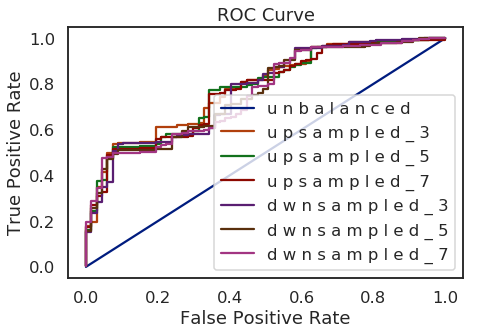

In [96]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in logistic_results.iterrows():
    label = ' '.join(idx)
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

## Random Forest Classifier

In [66]:
random_forest_list = list()

param_grid = {'max_depth':list(range(5,10)), 'n_estimators':[300,400,500], 
              'class_weight':['balanced','balanced_subsample']}
        
MOD = RandomForestClassifier(n_jobs=-1,random_state=42, oob_score=True)
CV = GridSearchCV(MOD, param_grid)

for Xtrain,Ytrain,name in zip(xdata_list, ydata_list, data_names):
    print (name)
    CV.fit(Xtrain, Ytrain)
    
    df = error_calc(CV, name)
    
    random_forest_list.append(df)

unbalanced
upsampled_3
upsampled_5
upsampled_7
dwnsampled_3
dwnsampled_5
dwnsampled_7


In [68]:
random_forest_results = (pd.concat(random_forest_list, axis=1).T
                         .set_index('data'))
random_forest_results[['accuracy','f1','recall','precision','auc', 'cm']]

,accuracy,f1,recall,precision,auc,cm
data,,,,,,
unbalanced,0.909341,0.944351,0.942761,0.945946,0.933162,"[[51, 16], [17, 280]]"
upsampled_3,0.901099,0.938144,0.919192,0.957895,0.934419,"[[55, 12], [24, 273]]"
upsampled_5,0.881868,0.924956,0.892256,0.960145,0.93364,"[[56, 11], [32, 265]]"
upsampled_7,0.870879,0.918261,0.888889,0.94964,0.932384,"[[53, 14], [33, 264]]"
dwnsampled_3,0.881868,0.924162,0.882155,0.97037,0.923715,"[[59, 8], [35, 262]]"
dwnsampled_5,0.840659,0.894545,0.828283,0.972332,0.920071,"[[60, 7], [51, 246]]"
dwnsampled_7,0.821429,0.879406,0.79798,0.979339,0.922031,"[[62, 5], [60, 237]]"


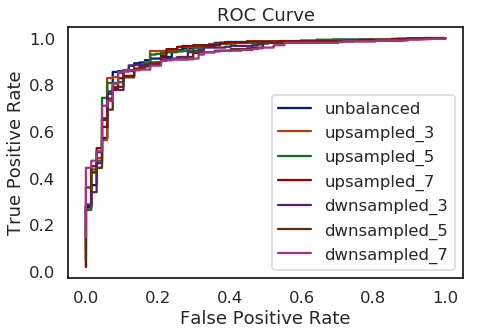

In [69]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in random_forest_results.iterrows():
    label = idx
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

## AdaBoost classification

In [74]:
ada_list = list()

param_grid = {'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 
              'n_estimators':[300,400,500]}

# param_grid = {'learning_rate':[0.1], 
#               'n_estimators':[500]}
        
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
MOD = AdaBoostClassifier(base_estimator=tree,
                            random_state=42)
CV = GridSearchCV(MOD, param_grid)

for Xtrain,Ytrain,name in zip(xdata_list, ydata_list, data_names):
    print (name)
    if name == 'unbalanced':
        
        #Xtrain = pd.DataFrame(Xtrain,columns=feat_cols)
        Xtrain.to_pickle('./pkl/13_model_tuning_Xtrain_ada_inner_{}.pkl'.format(name))

        #Ytrain = pd.DataFrame(Ytrain,columns=['zika_bool'])
        Ytrain.to_pickle('./pkl/13_model_tuning_Ytrain_ada_inner_{}.pkl'.format(name))

        Xtest.to_pickle('./pkl/13_model_tuning_Xtest_ada_inner_{}.pkl'.format(name))
        Ytest.to_pickle('./pkl/13_model_tuning_Ytest_ada_inner_{}.pkl'.format(name))

        CV.fit(Xtrain[feat_cols], Ytrain)

        with open('./pkl/13_model_tuning_ada_models_inner_{}.pkl'.format(name),'wb') as fh:
            dill.dump(CV,fh)

        Ypred_test = pd.DataFrame(CV.predict(Xtest[feat_cols]), 
                                  columns=['zika_bool'],
                                  index=Xtest.index)
        
        Ypred_train = pd.DataFrame(CV.predict(Xtrain[feat_cols]), 
                                   columns=['zika_bool'],
                                   index=Xtrain.index)

        Ypred_test.to_pickle('./pkl/13_model_tuning_Ypred_test_ada_inner_{}.pkl'.format(name))
        Ypred_train.to_pickle('./pkl/13_model_tuning_Ypred_train_ada_inner_{}.pkl'.format(name))

        print (confusion_matrix(Ytest, Ypred_test))

        df = error_calc(CV, name)

        ada_list.append(df)



unbalanced
[[ 45  22]
 [  8 289]]
upsampled_3


AttributeError: 'numpy.ndarray' object has no attribute 'to_pickle'

In [75]:
ada_results = pd.concat(ada_list, axis=1).T.set_index('data')
ada_results[['accuracy','f1','recall','precision','auc', 'cm']]

,accuracy,f1,recall,precision,auc,cm
data,,,,,,
unbalanced,0.917582,0.950658,0.973064,0.92926,0.933263,"[[45, 22], [8, 289]]"


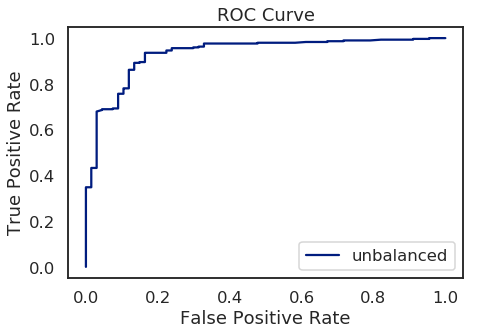

In [76]:
f = plt.figure()
f.set_size_inches(7,5)
ax = plt.axes()

colors = sns.color_palette()

for idx,dat in ada_results.iterrows():
    label = idx
    xdata = dat.roc_x
    ydata = dat.roc_y
    ax.plot(xdata, ydata, label=label)

ax.legend(loc=0)

_ = ax.set(xlabel='False Positive Rate', 
       ylabel='True Positive Rate',
       title='ROC Curve')

plt.tight_layout()

In [80]:
logistic_results.to_pickle('./pkl/13_model_tuning_logistic_models_df.pkl')

for idx,row in logistic_results.iterrows():
    print (idx)
    with open('./pkl/13_model_tuning_logistic_{}.pkl'.format(idx),'wb') as fh:
        dill.dump(row.model,fh)

unbalanced
upsampled_3
upsampled_5
upsampled_7
dwnsampled_3
dwnsampled_5
dwnsampled_7


In [79]:
random_forest_results.to_pickle('./pkl/13_model_tuning_random_forest_models_df.pkl')

for idx,row in random_forest_results.iterrows():
    print (idx)
    with open('./pkl/13_model_tuning_random_forest_{}.pkl'.format(idx),'wb') as fh:
        dill.dump(row.model,fh)

unbalanced
upsampled_3
upsampled_5
upsampled_7
dwnsampled_3
dwnsampled_5
dwnsampled_7


In [78]:
ada_results.to_pickle('./pkl/13_model_tuning_ada_models_df.pkl')

for idx,row in ada_results.iterrows():
    print (idx)
    with open('./pkl/13_model_tuning_ada_models_{}.pkl'.format(idx),'wb') as fh:
        dill.dump(row.model,fh)

unbalanced
